In [1]:
#https://wikidocs.net/175794

In [11]:
import sys
#IN_COLAB = "google.colab" in sys.modules

import random
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import time

import tensorflow as tf
from tensorflow.keras import optimizers, losses
from tensorflow.keras import Model
from collections import deque

from IPython.display import clear_output
#from tensorflow.python.framework.ops import disable_eager_execution
#disable_eager_execution()

In [3]:
solved_threshold = 195
episode_rewards = []
rolling_avg_rewards = []

target_update = 100

# INITIALIZING THE Q-PARAMETERS
hidden_size = 128
max_episodes = 1000  # Set total number of episodes to train agent on.
batch_size = 64

# Exploration parameters
epsilon = 1.0                 # Exploration rate
epsilon_decay = 0.99          # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 


In [4]:
# CREATING THE Dueling Q-Network
# Neural Network Model Defined at Here.
class Network(Model):
    def __init__(self, state_size: int, action_size: int, 
    ):
        """Initialization."""
        super(Network, self).__init__()
        
        self.num_action = action_size
        self.layer1 = tf.keras.layers.Dense(hidden_size, activation='relu')
        self.layer2 = tf.keras.layers.Dense(hidden_size, activation='relu')
        self.state  = tf.keras.layers.Dense(self.num_action)
        self.action = tf.keras.layers.Dense(self.num_action)

    def call(self, state):
        layer1 = self.layer1(state)
        layer2 = self.layer2(layer1)
        state = self.state(layer2)
        action = self.action(layer2)
        mean = tf.keras.backend.mean(action, keepdims=True)
        advantage = (action - mean)
        value = state + advantage        
        return value

class DQNAgent:
    def __init__(
        self, 
        env: gym.Env,
        batch_size: int,
        target_update: int,
    ):
        """Initialization.
        
        Args:
            env (gym.Env): openAI Gym environment
            memory_size (int): length of memory
            batch_size (int): batch size for sampling
            target_update (int): period for target model's hard update
            epsilon_decay (float): step size to decrease epsilon
            lr (float): learning rate
            max_epsilon (float): max value of epsilon
            min_epsilon (float): min value of epsilon
            gamma (float): discount factor
        """
        
        # CREATING THE Q-Network
        self.env = env
        
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        
        self.batch_size = batch_size
        # hyper parameters
        self.lr = 0.001
        self.target_update = target_update
        self.gamma = 0.99
        
        self.dqn = Network(self.state_size, self.action_size
                          )
        self.dqn_target = Network(self.state_size, self.action_size
                          )
        self.optimizers = optimizers.Adam(learning_rate =self.lr, )
        
        self.memory = deque(maxlen=2000)
        
        self._target_hard_update()
        
    # 3.4.1 EXPLORATION VS EXPLOITATION
    def get_action(self, state, epsilon):
        q_value = self.dqn(tf.convert_to_tensor([state], dtype=tf.float32))[0]
        # 3. Choose an action a in the current world state (s)
        # If this number < greater than epsilon doing a random choice --> exploration
        if np.random.rand() <= epsilon:
            action = np.random.choice(self.action_size)

        ## Else --> exploitation (taking the biggest Q value for this state)
        else:
            action = np.argmax(q_value) 

        return action
    
    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # 3.4.2 UPDATING THE Q-VALUE
    def train_step(self):
        mini_batch = random.sample(self.memory, self.batch_size)

        states      = [i[0] for i in mini_batch]
        actions     = [i[1] for i in mini_batch]
        rewards     = [i[2] for i in mini_batch]
        next_states = [i[3] for i in mini_batch]
        dones       = [i[4] for i in mini_batch]
        
        dqn_variable = self.dqn.trainable_variables
        with tf.GradientTape() as tape:
#            tape.watch(dqn_variable)
            
            states      = tf.convert_to_tensor(np.vstack(states), dtype=tf.float32)
            actions     = tf.convert_to_tensor(actions, dtype=tf.int32)
            rewards     = tf.convert_to_tensor(rewards, dtype=tf.float32)
            next_states = tf.convert_to_tensor(np.vstack(next_states), dtype=tf.float32)
            dones       = tf.convert_to_tensor(dones, dtype=tf.float32)
            
            # G_t   = r + gamma * v(s_{t+1})  if state != Terminal
            #       = r                       otherwise
            curr_Qs    = self.dqn(states)
            main_value = tf.reduce_sum(tf.one_hot(actions, self.action_size) * curr_Qs, axis=1)
            ## Obtain the Q' values by feeding the new state through our network
            next_Q_targs = self.dqn_target(next_states)
            next_action  = tf.argmax(next_Q_targs, axis=1)
            target_value = tf.reduce_sum(tf.one_hot(next_action, self.action_size) * next_Q_targs, axis=1)
            
            mask = 1 - dones
            target_value = rewards + self.gamma * target_value * mask 
            
            error = tf.square(main_value - target_value) * 0.5
            loss  = tf.reduce_mean(error)
            
        dqn_grads = tape.gradient(loss, dqn_variable)
        self.optimizers.apply_gradients(zip(dqn_grads, dqn_variable))
        
    def _target_hard_update(self):
        """Hard update: target <- local."""
        self.dqn_target.set_weights(self.dqn.get_weights())

In [5]:
# CREATING THE ENVIRONMENT
env_name = "CartPole-v1"
env = gym.make(env_name)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# train
agent = DQNAgent(
    env, 
#     memory_size, 
    batch_size, 
    target_update, 
#     epsilon_decay,
)

I0000 00:00:1734941118.466446 3924395 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734941118.483548 3924395 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734941118.483586 3924395 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734941118.485966 3924395 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734941118.486009 3924395 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [6]:
update_cnt    = 0
# 2.5 TRAINING LOOP
#List to contain all the rewards of all the episodes given to the agent
scores = []
    
# 2.6 EACH EPISODE    
for episode in range(max_episodes):

    state, _ = agent.env.reset()
    episode_reward = 0
    done = False  
        
    while not done:
        action = agent.get_action(state, epsilon)
            
        next_state, reward, done, _, _ = agent.env.step(action)
        agent.append_sample(state, action, reward, next_state, done)
        state = next_state

        episode_reward += reward

        if done:
            scores.append(episode_reward)
#            print("Episode " + str(episode+1) + ": " + str(episode_reward))
            break
            
        if (len(agent.memory) >= agent.batch_size):
            # 3.4.2 UPDATING THE Q-VALUE
            agent.train_step()
            update_cnt += 1
            
            # if hard update is needed
            if update_cnt % agent.target_update == 0:
                agent._target_hard_update()
    
    
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    # Record reward
    episode_rewards.append(episode_reward)
    rolling_avg = np.mean(episode_rewards[-5:])
    rolling_avg_rewards.append(rolling_avg)

    # Print progress
    print(f"Episode: {episode+1:3}/{max_episodes}, Reward: {episode_reward:+8.2f}, "
          f"Epsilon: {epsilon:.2f}, Rolling Avg: {rolling_avg:6.2f}, Terminated: {done} ")

    # Check if environment is solved
    if rolling_avg >= solved_threshold:
        print(f"Environment solved in {episode+1} episodes!")
        break
        

Episode:   1/200, Reward:   +27.00, Epsilon: 1.00, Rolling Avg:  27.00, Terminated: True 
Episode:   2/200, Reward:   +14.00, Epsilon: 1.00, Rolling Avg:  20.50, Terminated: True 
Episode:   3/200, Reward:   +25.00, Epsilon: 0.99, Rolling Avg:  22.00, Terminated: True 
Episode:   4/200, Reward:   +12.00, Epsilon: 0.99, Rolling Avg:  19.50, Terminated: True 
Episode:   5/200, Reward:   +12.00, Epsilon: 0.98, Rolling Avg:  18.00, Terminated: True 
Episode:   6/200, Reward:   +19.00, Epsilon: 0.98, Rolling Avg:  16.40, Terminated: True 
Episode:   7/200, Reward:   +23.00, Epsilon: 0.97, Rolling Avg:  18.20, Terminated: True 
Episode:   8/200, Reward:   +16.00, Epsilon: 0.97, Rolling Avg:  16.40, Terminated: True 
Episode:   9/200, Reward:   +21.00, Epsilon: 0.96, Rolling Avg:  18.20, Terminated: True 
Episode:  10/200, Reward:   +19.00, Epsilon: 0.96, Rolling Avg:  19.60, Terminated: True 
Episode:  11/200, Reward:   +19.00, Epsilon: 0.95, Rolling Avg:  19.60, Terminated: True 
Episode:  

Episode:  93/200, Reward:   +43.00, Epsilon: 0.63, Rolling Avg:  50.00, Terminated: True 
Episode:  94/200, Reward:   +68.00, Epsilon: 0.63, Rolling Avg:  54.00, Terminated: True 
Episode:  95/200, Reward:   +44.00, Epsilon: 0.63, Rolling Avg:  52.80, Terminated: True 
Episode:  96/200, Reward:   +13.00, Epsilon: 0.63, Rolling Avg:  43.40, Terminated: True 
Episode:  97/200, Reward:   +52.00, Epsilon: 0.62, Rolling Avg:  44.00, Terminated: True 
Episode:  98/200, Reward:   +51.00, Epsilon: 0.62, Rolling Avg:  45.60, Terminated: True 
Episode:  99/200, Reward:   +85.00, Epsilon: 0.62, Rolling Avg:  49.00, Terminated: True 
Episode: 100/200, Reward:  +105.00, Epsilon: 0.61, Rolling Avg:  61.20, Terminated: True 
Episode: 101/200, Reward:   +71.00, Epsilon: 0.61, Rolling Avg:  72.80, Terminated: True 
Episode: 102/200, Reward:  +141.00, Epsilon: 0.61, Rolling Avg:  90.60, Terminated: True 
Episode: 103/200, Reward:   +32.00, Epsilon: 0.60, Rolling Avg:  86.80, Terminated: True 
Episode: 1

Episode: 185/200, Reward:   +88.00, Epsilon: 0.40, Rolling Avg:  61.40, Terminated: True 
Episode: 186/200, Reward:  +122.00, Epsilon: 0.40, Rolling Avg:  83.20, Terminated: True 
Episode: 187/200, Reward:   +17.00, Epsilon: 0.40, Rolling Avg:  64.80, Terminated: True 
Episode: 188/200, Reward:  +133.00, Epsilon: 0.40, Rolling Avg:  81.20, Terminated: True 
Episode: 189/200, Reward:   +74.00, Epsilon: 0.40, Rolling Avg:  86.80, Terminated: True 
Episode: 190/200, Reward:  +259.00, Epsilon: 0.39, Rolling Avg: 121.00, Terminated: True 
Episode: 191/200, Reward: +1289.00, Epsilon: 0.39, Rolling Avg: 354.40, Terminated: True 
Environment solved in 191 episodes!


NameError: name 'model' is not defined

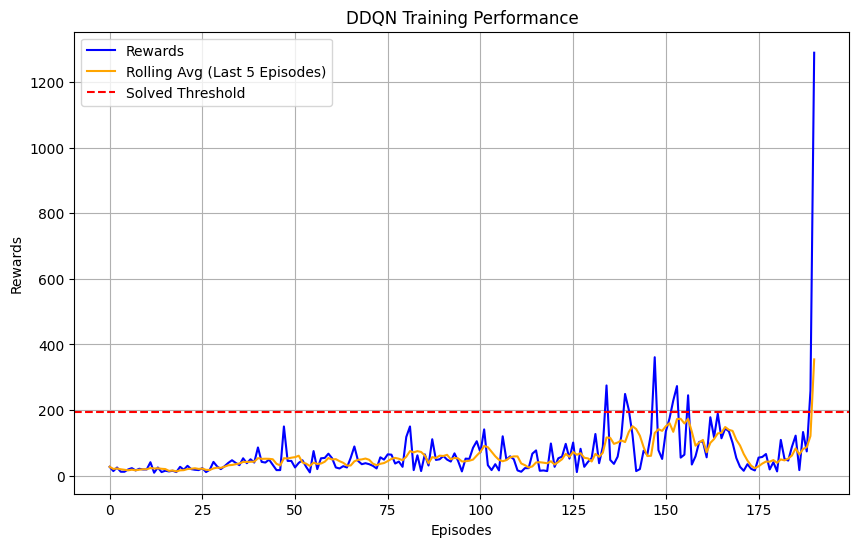

In [9]:
# Plot rewards with rolling average
plt.figure(figsize=(10, 6))
plt.plot(episode_rewards, label='Rewards', color='blue')
plt.plot(rolling_avg_rewards, label='Rolling Avg (Last 5 Episodes)', color='orange')
plt.axhline(y=solved_threshold, color='red', linestyle='--', label='Solved Threshold')
plt.title('D3QN Training Performance')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.grid()
plt.show()

In [13]:
# Testing for 10 episodes
start_time = time.time()
max_steps = 500

for e_test in range(10):  # Run 10 test episodes
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    
    steps = 0
    for s in range(max_steps):                            # we limit because sometimes it goes ad-aeternum
        # Use the trained model for testing
        action_vals = agent.dqn.predict(state, verbose=0)  # Predict action values
        action = np.argmax(action_vals[0])  # Choose the action with the highest Q-value

        next_state, reward, done, _, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        total_reward += reward
        state = next_state
        steps = steps + 1

        if done or (steps == max_steps):
            print(f"Test Episode: {e_test + 1}/10, Reward: {total_reward:.2f}, Steps: {steps:3}")
            break

end_time = time.time()
testing_duration = (end_time - start_time) / 60  # Convert to minutes
print(f"Testing completed in {testing_duration:.2f} minutes")

I0000 00:00:1734942131.586817 3924488 service.cc:146] XLA service 0x7f7b40005870 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734942131.586897 3924488 service.cc:154]   StreamExecutor device (0): NVIDIA T600 Laptop GPU, Compute Capability 7.5
2024-12-23 09:22:11.596725: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-23 09:22:11.884233: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1734942131.961082 3924488 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Test Episode: 1/10, Reward: 500.00, Steps: 500
Test Episode: 2/10, Reward: 500.00, Steps: 500
Test Episode: 3/10, Reward: 500.00, Steps: 500
Test Episode: 4/10, Reward: 500.00, Steps: 500
Test Episode: 5/10, Reward: 500.00, Steps: 500
Test Episode: 6/10, Reward: 500.00, Steps: 500
Test Episode: 7/10, Reward: 500.00, Steps: 500
Test Episode: 8/10, Reward: 500.00, Steps: 500
Test Episode: 9/10, Reward: 500.00, Steps: 500
Test Episode: 10/10, Reward: 500.00, Steps: 500
Testing completed in 3.25 minutes


In [14]:
import session_info
session_info.show(html=False)

-----
gymnasium           1.0.0
keras               3.6.0
matplotlib          3.9.2
numpy               1.26.4
session_info        1.0.0
tensorflow          2.17.1
-----
IPython             8.28.0
jupyter_client      8.6.3
jupyter_core        5.7.2
-----
Python 3.12.3 (main, Nov  6 2024, 18:32:19) [GCC 13.2.0]
Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39
-----
Session information updated at 2024-12-23 09:25
